# 0. Meta

Made on 2023-01-09

Redoing everything from scratch, just for Henry crater. Rushing bc LPSC submissions due soon lol.

---
# 1. Setup

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import os

In [2]:
"""
function [clon] = lon2clon(lon)  
    clon = mod(lon,360);
end

function [lon] = clon2lon(clon)  
    lon = mod(clon-180,360)-180;
end
"""

def lon2clon(lon):
    return lon % 360
def clon2lon(clon):
    return ((clon-180) % 360) - 180

def lat2cola(lat):
    return lat % 180
def cola2lat(cola):
    return ((cola-90) % 180) - 90
# def lat2cola(lat):
#     return lat + 90
# def cola2lat(cola):
#     return cola - 90

---
# 2. HPEs

## Load/Access GRS Data

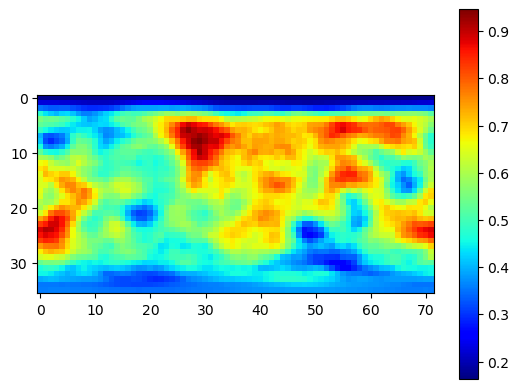

In [3]:
class GRS:
    def __init__(self, relpath_datafolder):
        self.relpath_datafolder = relpath_datafolder
        return
    
    
    def loadData(self):
        ## load data from files
        self.data = []
        path_datafolder = os.path.abspath(os.path.join(os.getcwd(), self.relpath_datafolder))
        for datafilename in (os.listdir(path_datafolder)):            
            if ".tab" in datafilename:

                # read file
                datafile = open(os.path.abspath(os.path.join(os.getcwd(), self.relpath_datafolder, datafilename)), 'r')
                rawdata = datafile.readlines()
                datafile.close()

                # populate lon/lat values if first time
                if self.data == []: # populate lon/lat values
                    # loop setups
                    prevlat = None
                    thisline = []
                    for rawdataline in rawdata:
                        rawdataline = rawdataline.split()
                        thislat = float(rawdataline[0])
                        thisclon = float(rawdataline[1])
                        thiscola = lat2cola(thislat)
                        thislon = clon2lon(thisclon)
                        # thisconc = rawdataline[2]
                        if thislat != prevlat and prevlat != None:
                            self.data.append(thisline)
                            thisline = []
                        thisline.append({"lon": thislon, "lat": thislat, "clon": thisclon, "cola": thiscola})
                        prevlat = thislat
                    self.data.append(thisline)

                # populate data values                
                elementname = datafilename[:datafilename.index("_")]
                counter = 0
                for i in range(len(self.data)):
                    for j in range(len(self.data[0])):
                        # rawdataline = rawdataline.split()
                        thisconc = float(rawdata[counter].split()[2])
                        self.data[i][j][elementname] = thisconc if thisconc != 9999.999 else -1
                        counter += 1
                        
        ## adjust longitude (realign to look like my qgis lol)
        lons = []
        for i in range(len(self.data[0])):
            lons.append(self.data[0][i]["lon"])
        # print(lons)
        for i in range(len(lons)):
            if lons[i] < 0:
                break
        for k in range(len(self.data)):
            self.data[k] = self.data[k][i:] + self.data[k][:i]
        return





    def visualize(self, elementname):
        test = []
        for i in range(len(self.data)):
            newline = []
            for j in range(len(self.data[0])):
                val = self.data[i][j][elementname]
                newline.append(val if val < 9000 else -1)
                # print
            test.append(newline)
        plt.imshow(test[::-1], cmap="jet")
        plt.colorbar()
        return
        
        
        
        
    
    def getConcentration(self, lon, lat, elementname):

        clon = lon2clon(lon)
        cola = lat2cola(lat)
        
        
        ## get lon/clon/lat/cola lists for easy searching

        lons = []
        for i in range(len(self.data[0])):
            lons.append(self.data[0][i]["lon"])
        # print(lons)
        clons = [lon2clon(lon) for lon in lons]
        # print(clons)

        lats = []
        for i in range(len(self.data)):
            lats.append(self.data[i][0]["lat"])
        # print(lats)
        colas = [lat2cola(lat) for lat in lats]
        # print(colas)
        
        
        
        
        ## get indexes and values for four nearest pixels
        
        if lon <= lons[0] or lon >= lons[-1]: # edge cases
            i_lon_left = len(lons)-1
            i_lon_right = 0
            lon_left = lons[i_lon_left]
            lon_right = lons[i_lon_right]
        else: # everything else
            for i in range(len(lons)):
                if lon < lons[i]:
                    i_lon_left = i-1
                    i_lon_right = i
                    lon_left = lons[i_lon_left]
                    lon_right = lons[i_lon_right]
                    break
                    
        if lat <= lats[0] or lat >= lats[-1]: # edge cases
            i_lat_bottom = len(lats)-1
            i_lat_top = 0
            lat_bottom = lats[i_lat_bottom]
            lat_top = lats[i_lat_top]
        else: # everything else
            for i in range(len(lats)):
                if lat < lats[i]:
                    i_lat_bottom = i-1
                    i_lat_top = i
                    lat_bottom = lats[i_lat_bottom]
                    lat_top = lats[i_lat_top]
                    break
                    
                    
        top_left = self.data[i_lat_top][i_lon_left][elementname]
        top_right = self.data[i_lat_top][i_lon_right][elementname]
        bottom_left = self.data[i_lat_bottom][i_lon_left][elementname]
        bottom_right = self.data[i_lat_bottom][i_lon_right][elementname]
        
        
        
        ## testing
        
        # print(f"{lat_bottom} {lon2clon(lon_left)} {bottom_left}")
        # print(f"{lat_bottom} {lon2clon(lon_right)} {bottom_right}")
        # print(f"{lat_top} {lon2clon(lon_left)} {top_left}")
        # print(f"{lat_top} {lon2clon(lon_right)} {top_right}")
        # print()
        # print(lon_left)
        # print(lon_right)
        # print(lat_bottom)
        # print(lat_top)
        
        
        
#         ## dealing with negative/NaN values
#         num_reals = 4
#         avg = 0
#         if top_left != -1:
#             num_reals -= 1
#             avg += top_left
#         if top_right != -1:
#             num_reals -= 1
#             avg += top_right
#         if bottom_left != -1:
#             num_reals -= 1
#             avg += bottom_left
#         if bottom_right != -1:
#             num_reals -= 1
#             avg += bottom_right
        
#         avg /= num_reals
                    
                    
                    
        ## bilinear interpolation
        
        clon_left = lon2clon(lon_left)
        clon_right = lon2clon(lon_right)
        cola_bottom = lat2cola(lat_bottom)
        cola_top = lat2cola(lat_top)
        
        
        if abs(i_lon_right - i_lon_left) == 1: # somewhere in the middle
            londist = abs(lon_right-lon_left)
            leftdist = (lon-lon_left) / londist
            rightdist = (lon_right-lon) / londist
        else: # on the edges
            londist = abs(clon_right-clon_left)
            leftdist = (clon-clon_left) / londist
            rightdist = (clon_right-clon) / londist
        # print(londist)
        topinterp = top_left*(1-leftdist) + top_right*(1-rightdist)
        bottominterp = bottom_left*(1-leftdist) + bottom_right*(1-rightdist)
        
        
        if abs(i_lat_top - i_lat_bottom) == 1: # somewhere in the middle
            latdist = abs(lat_top-lat_bottom)
            bottomdist = (lat-lat_bottom) / latdist
            topdist = (lat_top-lat) / latdist
        else: # on the edges
            latdist = abs(cola_top-cola_bottom)
            bottomdist = (cola-cola_bottom) / latdist
            topdist = (cola_top-cola) / latdist    
        # print(latdist)
        
        finalinterp = topinterp*(1-topdist) + bottominterp*(1-bottomdist)
        return finalinterp
        
        # return [londist, latdist]
        
        

#######################################
grs = GRS("data/GRS/smoothed")
grs.loadData()
# grs.data
grs.visualize("th")
# grs.getConcentration(-179, -79, "th")

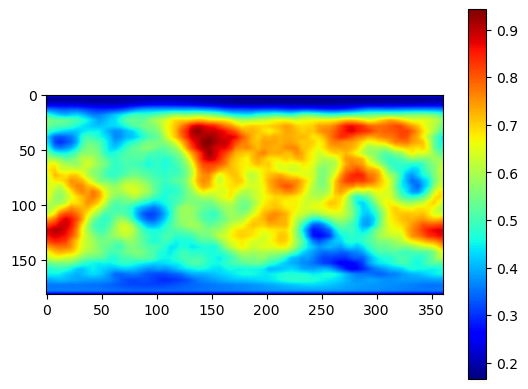

In [4]:
# Example: create fully interpolated map 

grs = GRS("data/GRS/smoothed")
grs.loadData()

test = []
for lat in range(-90,91):
    newline = []
    for lon in range(-180,181):
        newline.append(grs.getConcentration(lon,lat,"th"))
    test.append(newline)

plt.imshow(test[::-1], cmap="jet")
plt.colorbar()